In [8]:
# A few imports
import yt
import numpy as np
import trident
import matplotlib.pyplot as pl
from yt.units import kpc,mp
from yt.fields.particle_fields import add_volume_weighted_smoothed_field

In [3]:
%%time
# Import some FIRE2 data
fname = '/mnt/raid-project/murray/lakhlani/FIRE2_core/m12c_res56000/output/snapshot_600.hdf5'
ds = yt.load(fname)
# The center of the Halo was recovered in another notebook
center_Halo = [25277.66673046,34505.21241664,32868.48520185]
sp = ds.sphere(center_Halo, (10, "kpc"))
ang_mom_sphere = ds.sphere(center_Halo, (2, "kpc"))

yt : [INFO     ] 2020-05-21 09:29:19,355 Calculating time from 1.000e+00 to be 4.355e+17 seconds
yt : [INFO     ] 2020-05-21 09:29:19,357 Assuming length units are in kpc/h (comoving)
yt : [INFO     ] 2020-05-21 09:29:19,381 Parameters: current_time              = 4.3545571088051386e+17 s
yt : [INFO     ] 2020-05-21 09:29:19,382 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2020-05-21 09:29:19,383 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-05-21 09:29:19,385 Parameters: domain_right_edge         = [60000. 60000. 60000.]
yt : [INFO     ] 2020-05-21 09:29:19,386 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2020-05-21 09:29:19,387 Parameters: current_redshift          = 0.0
yt : [INFO     ] 2020-05-21 09:29:19,387 Parameters: omega_lambda              = 0.728
yt : [INFO     ] 2020-05-21 09:29:19,388 Parameters: omega_matter              = 0.272
yt : [INFO     ] 2020-05-21 09:29:19,389 Parameters: omega_radiation           = 0.

CPU times: user 7.07 s, sys: 1.7 s, total: 8.77 s
Wall time: 8.77 s


In [13]:
def find_normal_vector():
    # Finds the galaxy's normal vector by averaging the angular momentas
    # of the particles
    angular_momentum =[np.mean(ang_mom_sphere['angular_momentum_x']),
                       np.mean(ang_mom_sphere['angular_momentum_y']),
                       np.mean(ang_mom_sphere['angular_momentum_z'])]
    normalized_ang = np.array(angular_momentum)/np.linalg.norm(angular_momentum)
    print(normalized_ang)

In [14]:
find_normal_vector()

[ 0.90088129 -0.07389156 -0.42772998]


In [16]:
# Define a few vectors. parr is along the galaxy plane. 
# Perp is perpendicular to the galaxy plane
norm_perp = np.array([ 0.90088129,-0.07389156,-0.42772998])
norm_parr = yt.ortho_find(norm_perp)[1]

In [17]:
# Creates the field which will be required to compute the dispersion measure
def _ElectronDensity(field, data):
    xh= 1. - data['PartType0','Metallicity_00'] - data['PartType0','Metallicity_01']
    ne= xh * data['PartType0','Density'] * data['PartType0','ElectronAbundance'] / mp
    return ne
# Adds the field to the data set
ds.add_field(('PartType0', '_ElectronDensity'), function = _ElectronDensity, 
             sampling_type = 'particle', units='1/cm**3')

# smooths a particle field into a continuous field
fn = add_volume_weighted_smoothed_field(
      "PartType0", "particle_position", "particle_mass", "smoothing_length",
      "density", "_ElectronDensity",ds.field_info)

# Labels the new field
ds.field_info.alias(('gas', '_ElectronDensity'), fn[0])
ds.derived_field_list.append(('gas', '_ElectronDensity'))

yt : [WARNING  ] 2020-05-21 10:01:01,873 Field ('PartType0', '_ElectronDensity') already exists. To override use force_override=True.


In [21]:
def make_ray_plots(projection_axis, ray_axis, filename, all_angles = False):
    ''' 
    This function computes the dispersion measure along a light ray
    going through a simulated galaxy.
    Arguments:
    projection_axis: vector perpendicular to the light ray used to make a projection plot
    ray_axis: vector parallel to the light ray
    filename: name inditifer for images
    all_angles: Instead of creating a single off-axis projection plot,
    the function creates three on-axis projection plots when True
    '''
    
    # RAY CREATION
    ray_end = list(np.array(center_Halo) + 4*np.array(ray_axis))
    ray = trident.make_simple_ray(ds,
                                   start_position=center_Halo,
                                    end_position=ray_end,
                                    fields = ['_ElectronDensity','density','temperature'],
                                    data_filename="{}.h5".format(filename))
    
    # GALAXY PLOTS
    if all_angles:
        # Creates three on-axis projection plots
        axes=['x','y','z']
        for axis in axes:
            prj_x = yt.ProjectionPlot(ds, axis, 'density', width=10*kpc, data_source = sp,
                                      center=center_Halo)
            prj_x.annotate_ray(ray)
            prj_x.save(filename+'_galaxy_{}.pdf'.format(str(axis)))
        
    else:
        image = yt.OffAxisProjectionPlot(ds, projection_axis, fields= 'density', 
                                         center= center_Halo, width=10, data_source = sp)
        image.annotate_ray(ray)
        image.save(filename+'_galaxy.pdf')
    
        # COMPUTING THE DM
        length = np.linalg.norm(np.array(center_Halo)-np.array(ray_end))
        int_elec_dens = []
        int_total = 0
        # Finding the entry where arc_length>1kpc:
        for i in range(len(ray.data['_ElectronDensity'])):
            # Convert in pc/cm^-3 from kpc/h
            int_total += ray.data['_ElectronDensity'][i]*ray.data['dl'][i]*60000*1000/0.7
            int_elec_dens.append(float(int_total))
        
        # LIGHT RAY DATA PLOTS
        fig, axs = pl.subplots(2,2)

        axs[0,0].plot(np.linspace(0,length,len(ray.data['density'])), 
                      np.log10(ray.data['density']))
        axs[0,0].set_xlabel('Arc Length (kpc)')
        axs[0,0].set_ylabel('Density '+r'$\log\left(\frac{g}{cm^3}\right)$')

        axs[0,1].plot(np.linspace(0,length,len(ray.data['temperature'])), 
                      np.log10(ray.data['temperature']))
        axs[0,1].set_xlabel('Arc Length (kpc)')
        axs[0,1].set_ylabel('Temperature '+r'$\log(K)$')

        axs[1,0].plot(np.linspace(0,length,len(ray.data['_ElectronDensity'])), 
                np.log10(ray.data['_ElectronDensity']))
        axs[1,0].set_xlabel('Arc Length (kpc)')
        axs[1,0].set_ylabel('Electron Density '+r'$\log(cm^{-3})$')
        
        axs[1,1].title.set_text('DM = {}'.format(round(int_elec_dens[-1], 2)))
        axs[1,1].plot(np.linspace(0,length,len(int_elec_dens)), np.log10(int_elec_dens))
        axs[1,1].set_xlabel('Arc Length (kpc)')
        axs[1,1].set_ylabel('DM '+r'$\log(cm^{-2})$')

        pl.subplots_adjust(left = 0.20,right = 0.9,bottom = 0.2,top = 0.9,
                           wspace = 0.4,hspace = 0.8)
        fig.savefig(filename+'_subplots.pdf')
    return ray

yt : [INFO     ] 2020-05-21 10:05:17,610 Getting segment at z = 0.0: [0.42129445 0.57508687 0.54780809] unitary to [0.42132304 0.57508687 0.54786831] unitary.
/home/hlamarre/.local/lib/python3.7/site-packages/yt/units/yt_array.py:1417: RuntimeWarning: invalid value encountered in true_divide
  out=out, **kwargs)
yt : [INFO     ] 2020-05-21 10:05:17,614 Getting subsegment: [0.4212944455076667 unitary, 0.5750868736106668 unitary, 0.5478080866975 unitary] to [0.42132303900626794 unitary, 0.5750868736106668 unitary, 0.5478683100840055 unitary].
yt : [INFO     ] 2020-05-21 10:07:45,903 Saving field data to yt dataset: ray_parr.h5.
yt : [INFO     ] 2020-05-21 10:07:46,106 Parameters: current_time              = 4.3545571088051386e+17 s
yt : [INFO     ] 2020-05-21 10:07:46,107 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2020-05-21 10:07:46,108 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2020-05-21 10:07:46,109 Parameters: domain_right_e

yt : [INFO     ] 2020-05-21 10:08:33,578 Returning an all_data data container.
yt : [INFO     ] 2020-05-21 10:08:33,589 Returning an all_data data container.
yt : [INFO     ] 2020-05-21 10:08:33,599 Returning an all_data data container.
yt : [INFO     ] 2020-05-21 10:08:33,610 Returning an all_data data container.
yt : [INFO     ] 2020-05-21 10:08:33,620 Returning an all_data data container.
yt : [INFO     ] 2020-05-21 10:08:33,631 Returning an all_data data container.
yt : [INFO     ] 2020-05-21 10:08:33,642 Returning an all_data data container.
yt : [INFO     ] 2020-05-21 10:08:33,652 Returning an all_data data container.
yt : [INFO     ] 2020-05-21 10:08:33,663 Returning an all_data data container.
yt : [INFO     ] 2020-05-21 10:08:33,674 Returning an all_data data container.
yt : [INFO     ] 2020-05-21 10:08:33,684 Returning an all_data data container.
yt : [INFO     ] 2020-05-21 10:08:33,695 Returning an all_data data container.
yt : [INFO     ] 2020-05-21 10:08:33,705 Returning a

yt : [INFO     ] 2020-05-21 10:08:34,695 Returning an all_data data container.
yt : [INFO     ] 2020-05-21 10:08:34,705 Returning an all_data data container.
yt : [INFO     ] 2020-05-21 10:08:34,717 Returning an all_data data container.
yt : [INFO     ] 2020-05-21 10:08:34,727 Returning an all_data data container.
yt : [INFO     ] 2020-05-21 10:08:34,738 Returning an all_data data container.
yt : [INFO     ] 2020-05-21 10:08:34,748 Returning an all_data data container.
yt : [INFO     ] 2020-05-21 10:08:34,759 Returning an all_data data container.
yt : [INFO     ] 2020-05-21 10:08:34,770 Returning an all_data data container.
yt : [INFO     ] 2020-05-21 10:08:34,781 Returning an all_data data container.
yt : [INFO     ] 2020-05-21 10:08:34,791 Returning an all_data data container.
yt : [INFO     ] 2020-05-21 10:08:34,802 Returning an all_data data container.
yt : [INFO     ] 2020-05-21 10:08:34,813 Returning an all_data data container.
yt : [INFO     ] 2020-05-21 10:08:34,824 Returning a

CPU times: user 2min 14s, sys: 1min 3s, total: 3min 18s
Wall time: 3min 18s


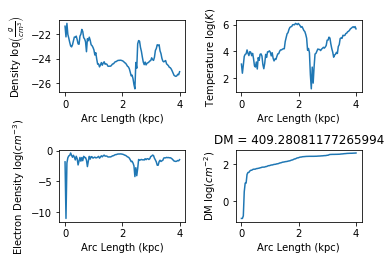

In [22]:
%%time
ray_parr = make_ray_plots(norm_perp, norm_parr, 'ray_parr')

yt : [INFO     ] 2020-05-21 10:10:15,998 Getting segment at z = 0.0: [0.42129445 0.57508687 0.54780809] unitary to [0.4213545  0.57508195 0.54777957] unitary.
yt : [INFO     ] 2020-05-21 10:10:16,002 Getting subsegment: [0.4212944455076667 unitary, 0.5750868736106668 unitary, 0.5478080866975 unitary] to [0.42135450426042037 unitary, 0.5750819475066596 unitary, 0.5477795713654587 unitary].
yt : [INFO     ] 2020-05-21 10:12:42,455 Saving field data to yt dataset: ray_perp.h5.
yt : [INFO     ] 2020-05-21 10:12:42,662 Parameters: current_time              = 4.3545571088051386e+17 s
yt : [INFO     ] 2020-05-21 10:12:42,663 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2020-05-21 10:12:42,664 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2020-05-21 10:12:42,665 Parameters: domain_right_edge         = [60000. 60000. 60000.] code_length
yt : [INFO     ] 2020-05-21 10:12:42,666 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2020-0

yt : [INFO     ] 2020-05-21 10:13:30,374 Returning an all_data data container.
yt : [INFO     ] 2020-05-21 10:13:30,385 Returning an all_data data container.
yt : [INFO     ] 2020-05-21 10:13:30,398 Returning an all_data data container.
yt : [INFO     ] 2020-05-21 10:13:30,409 Returning an all_data data container.
yt : [INFO     ] 2020-05-21 10:13:30,420 Returning an all_data data container.
yt : [INFO     ] 2020-05-21 10:13:30,432 Returning an all_data data container.
yt : [INFO     ] 2020-05-21 10:13:30,444 Returning an all_data data container.
yt : [INFO     ] 2020-05-21 10:13:30,455 Returning an all_data data container.
yt : [INFO     ] 2020-05-21 10:13:30,467 Returning an all_data data container.
yt : [INFO     ] 2020-05-21 10:13:30,478 Returning an all_data data container.
yt : [INFO     ] 2020-05-21 10:13:30,490 Returning an all_data data container.
yt : [INFO     ] 2020-05-21 10:13:30,500 Returning an all_data data container.
yt : [INFO     ] 2020-05-21 10:13:30,512 Returning a

CPU times: user 2min 12s, sys: 1min 3s, total: 3min 15s
Wall time: 3min 15s


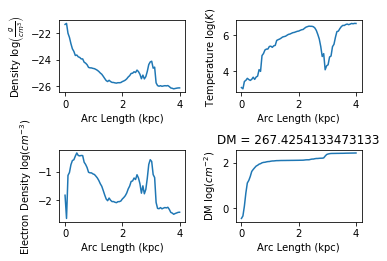

In [23]:
%%time
ray_perp = make_ray_plots(norm_parr, norm_perp, 'ray_perp')